In [17]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt


In [21]:

def load_ecg_data(ecg_directory, diagnostics_file):
    # Read diagnostics file
    diagnostics_df = pd.read_csv(diagnostics_file)

    data = []
    labels = []

    for index, row in diagnostics_df.iterrows():
        # Get filename and label from diagnostics file
        ecg_file = row['FileName']
        label = row['Rhythm']

        # Add the file extension if it's missing
        if not ecg_file.endswith('.csv'):
            ecg_file = ecg_file + '.csv'

        # Read ECG file
        ecg_df = pd.read_csv(os.path.join(ecg_directory, ecg_file),header=None)

        # Get first lead data
        lead_data = ecg_df.iloc[:, 0].values

        data.append(lead_data)
        labels.append(label)

    return data, labels



In [22]:
# Example usage
ecg_directory = '/Users/aman/Downloads/ECGDataDenoised/'
diagnostics_file = '/Users/aman/Downloads/ecg/Diagnostics.csv'

data, labels = load_ecg_data(ecg_directory, diagnostics_file)

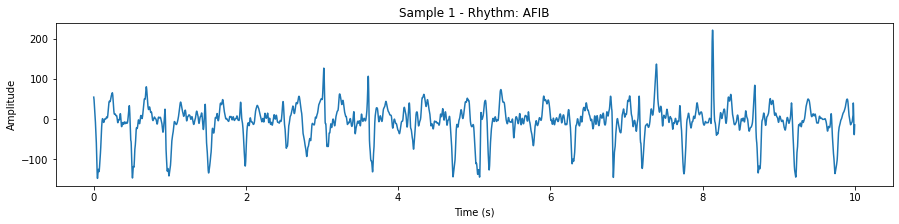

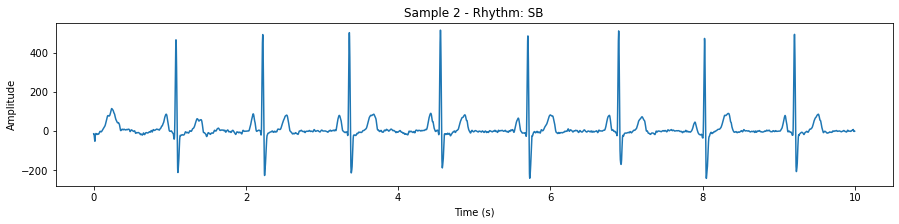

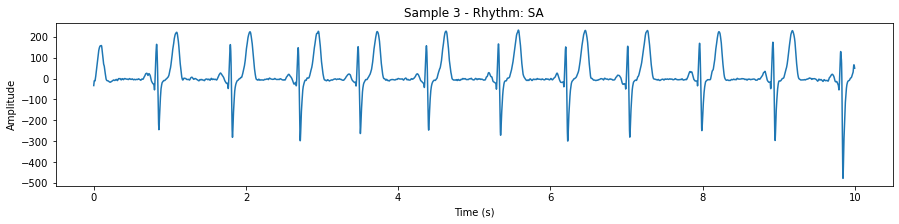

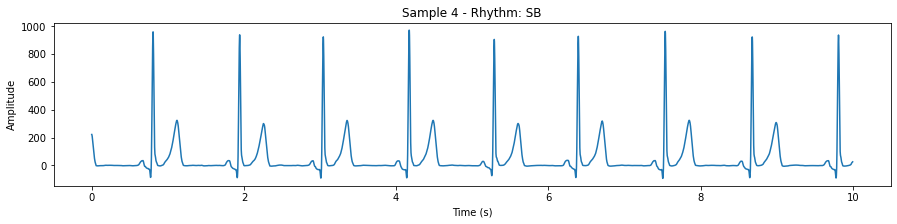

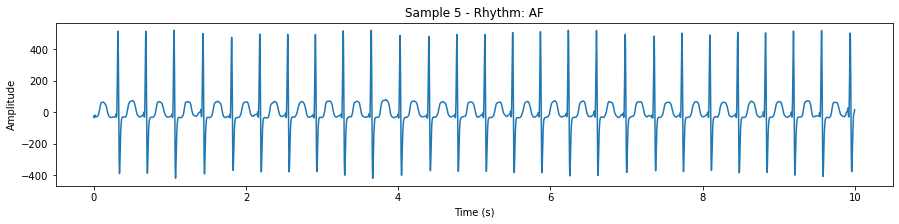

In [18]:
import numpy as np

def plot_ecg_samples(data, labels, fs=500, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(15, 3))
        
        # Create time axis in seconds
        time_axis = np.arange(0, len(data[i])) / fs

        plt.plot(time_axis, data[i])
        plt.title(f"Sample {i + 1} - Rhythm: {labels[i]}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

# Example usage
plot_ecg_samples(data, labels, fs=500, num_samples=5)


In [24]:
def print_sample_lengths(data, target_length=5000):
    for i, sample in enumerate(data):
        if len(sample) != target_length:
            print(f"Sample {i}: Length = {len(sample)}")

# Example usage
print_sample_lengths(data)


Sample 1789: Length = 1926


In [25]:
def filter_samples(data, labels, target_length=5000):
    filtered_data = []
    filtered_labels = []

    for sample, label in zip(data, labels):
        if len(sample) == target_length:
            filtered_data.append(sample)
            filtered_labels.append(label)

    return filtered_data, filtered_labels

# Example usage
filtered_data, filtered_labels = filter_samples(data, labels)


In [34]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare the data
X = np.array(filtered_data)
y = np.array(filtered_labels)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create PyTorch datasets
train_dataset = TensorDataset(torch.from_numpy(X_train).unsqueeze(1).float(), torch.from_numpy(y_train).long())
test_dataset = TensorDataset(torch.from_numpy(X_test).unsqueeze(1).float(), torch.from_numpy(y_test).long())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [38]:

import torch
import torch.nn as nn

class EcgCnn(nn.Module):
    def __init__(self, num_classes=11):
        super(EcgCnn, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=9, padding=4)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64 * 625, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.dropout1(self.pool3(self.relu3(self.bn3(self.conv3(x)))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.dropout2(self.relu4(self.bn4(self.fc1(x))))
        x = self.fc2(x)

        return x


In [39]:
import torch.optim as optim

# Create the model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EcgCnn(num_classes).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total


           


In [40]:
# Test function
def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total



In [ ]:
# Number of epochs
num_epochs = 20

# Training loop
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Epoch: {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc * 100:.2f}%")
    print("-" * 40)


Epoch: 1/20
Train Loss: 0.2417 | Train Acc: 92.17%
Test Loss: 0.8553 | Test Acc: 77.55%
----------------------------------------
Epoch: 2/20
Train Loss: 0.2287 | Train Acc: 92.40%
Test Loss: 0.7895 | Test Acc: 79.57%
----------------------------------------
Epoch: 3/20
Train Loss: 0.1976 | Train Acc: 93.39%
Test Loss: 0.8341 | Test Acc: 78.11%
----------------------------------------
Epoch: 4/20
Train Loss: 0.1835 | Train Acc: 93.94%
Test Loss: 0.8823 | Test Acc: 78.30%
----------------------------------------
Epoch: 5/20
Train Loss: 0.1736 | Train Acc: 94.38%
Test Loss: 0.9539 | Test Acc: 77.45%
----------------------------------------
Epoch: 6/20
Train Loss: 0.1552 | Train Acc: 94.96%
Test Loss: 0.9039 | Test Acc: 78.77%
----------------------------------------
Epoch: 7/20
Train Loss: 0.1554 | Train Acc: 95.35%
Test Loss: 0.9374 | Test Acc: 77.78%
----------------------------------------
Epoch: 8/20
Train Loss: 0.1478 | Train Acc: 95.06%
Test Loss: 0.9596 | Test Acc: 79.66%
---------